In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageFile
import seaborn as sns
import gc

In [2]:
# Image Parameters
IMG_SIZE = 224
BATCH_SIZE = 4
EPOCHS = 10
NUM_CLASSES = 7

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define Transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Dataset
data_dir = "/kaggle/input/undersample-majority/undersample_split/1.train"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Spatial Attention Mechanism
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out)

# RCA-CapsNet Model with Spatial Attention
class RCA_CapsNet(nn.Module):
    def __init__(self, num_classes):
        super(RCA_CapsNet, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.attention = SpatialAttention()

        self.primary_caps = nn.Linear(256 * 28 * 28, 256 * 6 * 6)
        self.digit_caps = nn.Linear(256 * 6 * 6, 8)
        self.embedding = nn.Linear(8, 128)
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.feature_extractor(x)  # Shape: [B, 256, 28, 28]
        attention_weights = self.attention(x)  
        x = x * attention_weights  # Apply attention
        
        x = x.view(x.size(0), -1)  # Flatten to [B, 256*28*28]
        x = self.primary_caps(x)   # Shape: [B, 256*6*6]
        x = x.view(x.size(0), -1, 8)  # Reshape to [B, -1, 8]
        x = self.embedding(x)      # Shape: [B, -1, 128]
        x = x.mean(dim=1)          # Global average pooling to [B, 128]
        x = self.fc(x)             # Shape: [B, num_classes]
        return x

# Contrastive Loss Function (not used in this code, but kept for reference)
def contrastive_loss(output1, output2, label, margin=1.0):
    euclidean_distance = nn.functional.pairwise_distance(output1, output2)
    loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                      label * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    return loss

# Initialize Model, Loss Function, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RCA_CapsNet(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        del images, labels, outputs, loss
        torch.cuda.empty_cache()
        gc.collect()
        
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification Report
class_labels = dataset.classes
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Epoch [1/10], Loss: 1.8832
Epoch [2/10], Loss: 1.5431
Epoch [3/10], Loss: 1.3205
Epoch [4/10], Loss: 1.2261
Epoch [5/10], Loss: 1.0796
Epoch [6/10], Loss: 1.0361
Epoch [7/10], Loss: 0.9671
Epoch [8/10], Loss: 0.8665
Epoch [9/10], Loss: 0.7934
Epoch [10/10], Loss: 0.8434
Classification Report:
                         precision    recall  f1-score   support

         1. No DR signs       0.41      0.47      0.44        15
2. Mild (or early) NPDR       1.00      1.00      1.00        11
       3. Moderate NPDR       0.47      0.58      0.52        12
         4. Severe NPDR       0.58      0.50      0.54        14
    5. Very Severe NPDR       0.55      0.46      0.50        13
                 6. PDR       0.46      0.57      0.51        21
        7. Advanced PDR       1.00      0.25      0.40         8

               accuracy                           0.55        94
              macro avg       0.64      0.55      0.56        94
           weighted avg       0.59      0.55      0.55

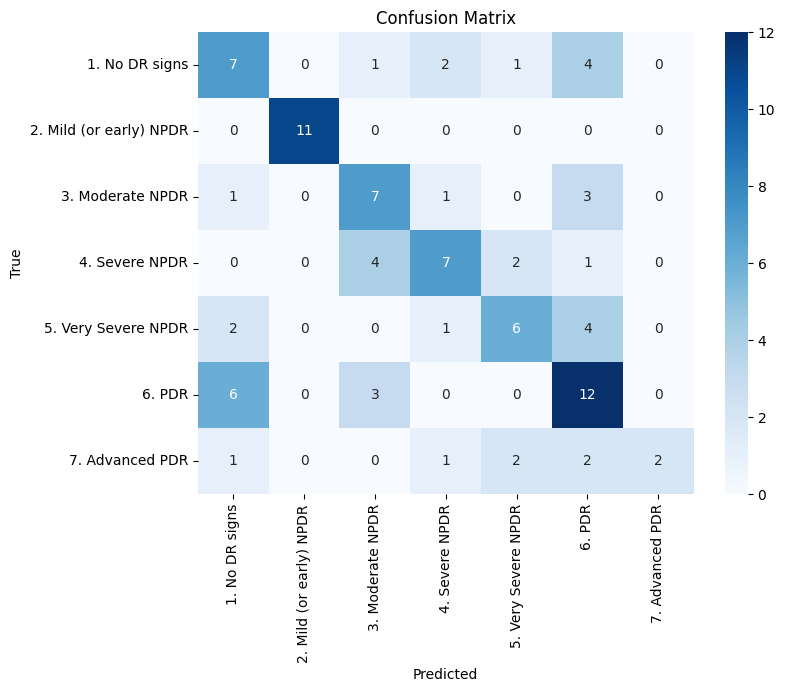

Accuracy: 0.5532
Precision: 0.6384
Recall (Sensitivity): 0.5476
F1-Score: 0.5579
Specificity: 0.8615


In [3]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compute Metrics
TN = np.diag(cm).sum() - cm.sum(axis=0)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
accuracy = np.trace(cm) / np.sum(cm)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {np.mean(precision):.4f}")
print(f"Recall (Sensitivity): {np.mean(recall):.4f}")
print(f"F1-Score: {np.mean(f1_score):.4f}")
print(f"Specificity: {np.mean(specificity):.4f}")